In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.Greedy_algorithm import *
from Advertising.learners.GTS_Learner import *
from Advertising.learners.GTS_SW_Learner import *
from experiment_utilities import*

import math

from tqdm.autonotebook import tqdm
from Advertising.learners.TS_sliding_window import *
import itertools

arms = arms_creation(seed=30291, number_of_arms=20)

seed = 6789
random.seed(seed)
only_first = True
#initialization
n_try = 1
variance = 500
expected_values = []
interval = 5000
n_experiments=20000
sw_size = 2000
#sw_size = math.isqrt(n_experiments)
n_change = (int)(n_experiments/interval)

lambdas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')




with open("Config/estimated_influence.json", "r"):
    data = json.load(open("Config/estimated_influence.json"))

active_by_influence_reward = np.array(data.get("estimated_influence"))



with open('Config/clairvoyants_sw.json', 'r') as file:
    clairvoyants = json.load(file)
clairvoyants_first = clairvoyants.get('clairvoyant_f_sw')
clairvoyants_all = clairvoyants.get('clairvoyant_a_sw')


with open('Config/bids.json', 'r') as file:
    bids = json.load(file)
    list_of_bids = bids.get('bids')
#print(list_of_bids)


In [2]:
ts_learner = GTS_SW_Learner(arms, variance=variance, size_SW=sw_size, ad_id=1)
print(ts_learner.tau0)
print(ts_learner.u0)
ts_learner2 = GTS_SW_Learner(arms, variance=variance, size_SW=sw_size, ad_id=1)

[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001
 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
moving_avarage_only_mean = []

moving_avarage_only= experiment(n_experiments, ts_learner, list_of_bids, social_network, arms, only_first, sliding_window = True, interval=interval)
moving_avarage_only_mean.append(moving_avarage_only)
cum_mov_avarage_only = np.cumsum(np.mean(moving_avarage_only_mean, axis=0))



  0%|          | 0/20000 [00:00<?, ?it/s]

iteration0
1
0.0021
iteration1
1
0.0021
iteration2
1
0.0021
iteration3
1
0.0021
iteration4
1
0.0021
iteration5
1
0.0021
iteration6
1
0.0021
iteration7
1
0.0021
iteration8
1
0.0021
iteration9
1
0.0021
iteration10
1
0.0021
iteration11
1
0.0021
iteration12
1
0.0021
iteration13
1
0.0021
iteration14
1
0.0021
iteration15
1
0.0021
iteration16
1
0.0021
iteration17
1
0.0021
iteration18
1
0.0021
iteration19
1
0.0021
iteration20
2
0.0060999999999999995
iteration21
2
0.0060999999999999995
iteration22
2
0.0060999999999999995
iteration23
2
0.0060999999999999995
iteration24
2
0.0060999999999999995
iteration25
2
0.0060999999999999995
iteration26
2
0.0060999999999999995
iteration27
2
0.0060999999999999995
iteration28
2
0.0060999999999999995
iteration29
2
0.0060999999999999995
iteration30
2
0.0060999999999999995
iteration31
2
0.0060999999999999995
iteration32
2
0.0060999999999999995
iteration33
2
0.0060999999999999995
iteration34
2
0.0060999999999999995
iteration35
2
0.0060999999999999995
iteration36
2


In [4]:
clairvoyant_non_cum_only = []
for i in range(0, len(clairvoyants_first)):
    for j in range(0, interval):
        #clairvoyant_non_cum.append(expected_values_list_only[i][index])
        clairvoyant_non_cum_only.append(clairvoyants_first[i])

clairvoyant_cum_only = clairvoyant_non_cum_only.append(clairvoyant_non_cum_only[-1])
clairvoyant_cum_only = np.cumsum(clairvoyant_non_cum_only)




Graphic for TS with ads only in first position


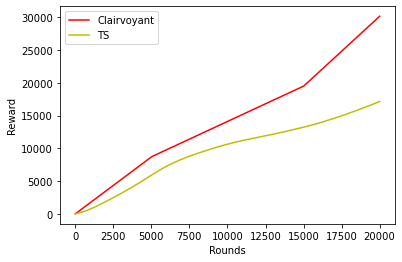

In [5]:
print("Graphic for TS with ads only in first position")

plt.figure(1)
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.plot(clairvoyant_cum_only, 'r')
plt.plot(cum_mov_avarage_only, 'y')
plt.legend(["Clairvoyant", "TS" ])

<ErrorbarContainer object of 3 artists>

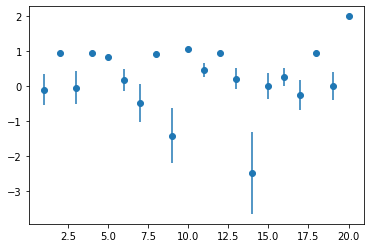

In [6]:
array = [i+1 for i in range(0, 20)]
plt.figure(0)
plt.errorbar(array, ts_learner.u0, yerr=(1/ts_learner.tau0), fmt='o')

Graphic for TS with ads only in first position


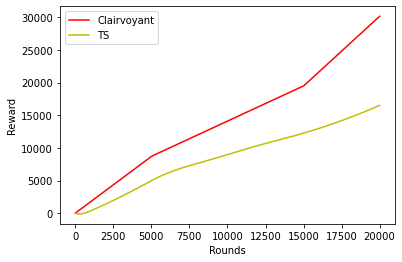

In [ ]:

print("Graphic for TS with ads only in first position")

plt.figure(1)
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.plot(clairvoyant_cum_only, 'r')
plt.plot(cum_mov_avarage_only, 'y')
plt.legend(["Clairvoyant", "TS" ])


In [7]:


moving_avarage_all_mean = []
for j in range(0, n_try):
    print("This is TS number " + str(j))

    moving_avarage_all= experiment(n_experiments, ts_learner2, list_of_bids, social_network, arms, not only_first, sliding_window=True,  interval=interval)
    moving_avarage_all_mean.append(moving_avarage_all)
# plotting_means = np.mean(thing_to_plot_only_mean, axis=0)
# print(plotting_means)
#moving_avarage_all_mean = moving_avarage_all_mean.pop(1)
cum_mov_avarage_all = np.cumsum(np.mean(moving_avarage_all_mean, axis=0))
#print(plotting_means_cum_sum)


This is TS number 0


  0%|          | 0/20000 [00:00<?, ?it/s]

iteration0
1
0.0021
iteration1
1
0.0021
iteration2
1
0.0021
iteration3
1
0.0021
iteration4
1
0.0021
iteration5
1
0.0021
iteration6
1
0.0021
iteration7
1
0.0021
iteration8
1
0.0021
iteration9
1
0.0021
iteration10
1
0.0021
iteration11
1
0.0021
iteration12
1
0.0021
iteration13
1
0.0021
iteration14
1
0.0021
iteration15
1
0.0021
iteration16
1
0.0021
iteration17
1
0.0021
iteration18
1
0.0021
iteration19
2
0.0060999999999999995
iteration20
2
0.0060999999999999995
iteration21
2
0.0060999999999999995
iteration22
2
0.0060999999999999995
iteration23
2
0.0060999999999999995
iteration24
2
0.0060999999999999995
iteration25
1
0.0021
iteration26
2
0.0060999999999999995
iteration27
2
0.0060999999999999995
iteration28
2
0.0060999999999999995
iteration29
2
0.0060999999999999995
iteration30
2
0.0060999999999999995
iteration31
2
0.0060999999999999995
iteration32
2
0.0060999999999999995
iteration33
2
0.0060999999999999995
iteration34
2
0.0060999999999999995
iteration35
2
0.0060999999999999995
iteration36
3


In [ ]:

# print("THE BEST ARM FOR EXPERIMENT ONLY FIRST IS:",
#       arms[best_arm_index], "INDEX", best_arm_index)
# print("THE BEST ARM FOR EXPERIMENT total IS:",
#       arms[best_arm_index2], "INDEX", best_arm_index2)

# array = [i+1 for i in range(0, 20)]


# plt.figure(0)
# plt.errorbar(array, expected_values, yerr=(1/ts_learner.tau0), fmt='o')
# plt.figure(1)
# plt.errorbar(array, expected_values2, yerr=(1/ts_learner2.tau0), fmt='o')

# plt.show()




Graphic for TS with ads in all positions


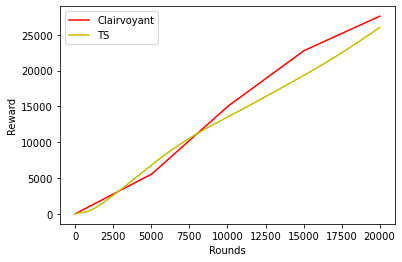

In [8]:

## Here i calculate the clairvoyant running the algorithm in a static enviroment as much as the times i vary the adversarial bids
#clairvoyant_only = []

clairvoyant_non_cum_all = []
for i in range(0, len(clairvoyants_all)):
    for j in range(0, interval):
        #clairvoyant_non_cum.append(expected_values_list_only[i][index])
        clairvoyant_non_cum_all.append(clairvoyants_all[i])

clairvoyant__non_cum_all = clairvoyant_non_cum_all.append(clairvoyant_non_cum_all[-1])
clairvoyant_cum_all = np.cumsum(clairvoyant_non_cum_all)

# clairvoyant_non_cum_only = []
# for i in range(0, len(clairvoyants_first)):
#     for j in range(0, interval):
#         #clairvoyant_non_cum.append(expected_values_list_only[i][index])
#         clairvoyant_non_cum_only.append(clairvoyants_first[i])

# clairvoyant_cum_only = clairvoyant_non_cum_only.append(clairvoyant_non_cum_only[-1])
# clairvoyant_cum_only = np.cumsum(clairvoyant_non_cum_only)




# for i in range(0, len(exp_rewards_per_window)):
#     if i==0:
#         value_cumulative = exp_rewards_per_window[i]
#         #value_cumulative = expected_values_list_only[i][index]
#     else:
#         value_cumulative += exp_rewards_per_window[i]
#         #value_cumulative += expected_values_list_only[i][index]
#     for j in range(0, interval):
#         clairvoyant_only.append(value_cumulative)
        


print("Graphic for TS with ads in all positions")
plt.figure(0)
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.plot(clairvoyant_cum_all, 'r')
plt.plot(cum_mov_avarage_all, 'y')
plt.legend(["Clairvoyant", "TS" ])


# print("Graphic for TS with ads only in first position")

# plt.figure(1)
# plt.ylabel("Reward")
# plt.xlabel("Rounds")
# plt.plot(clairvoyant_cum_only, 'r')
# plt.plot(cum_mov_avarage_only, 'y')
# plt.legend(["Clairvoyant", "TS" ])



# print(len(clairvoyant_cum_only))
# print(len(cum_mov_avarage_only))

# regret_only = []
# for i in range(0, len(cum_mov_avarage_only)):
#     regret_only.append(clairvoyant_cum_only[i] - cum_mov_avarage_only[i])


# regret_all = []
# for i in range(0, len(cum_mov_avarage_all)):
#     regret_all.append(clairvoyant_cum_all[i] - cum_mov_avarage_all[i])

# plt.figure(2)
# plt.ylabel("Regret")
# plt.xlabel("Rounds")
# plt.plot(regret_only, 'g')

# plt.figure(3)
# plt.ylabel("Regret")
# plt.xlabel("Rounds")
# plt.plot(regret_all, 'g')

In [ ]:
# clairvoyant_all = []

# for i,index in enumerate(best_arm_indexes_all):
#     for j in range(0, interval):
#         clairvoyant_all.append(expected_values_list_all[i][index])

# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])

        

# plt.figure(0)
# plt.ylabel("Reward")
# plt.xlabel("Rounds")
# plt.plot(clairvoyant_all, 'r')
# plt.plot(thing_to_plot_all, 'y')
# plt.legend(["Clairvoyant", "TS" ])


# regret_all = []
# for i in range(0, len(thing_to_plot_all)):
#     regret_all.append(clairvoyant_all[i] - thing_to_plot_all[i])




# plt.figure(1)
# plt.ylabel("Regret")
# plt.xlabel("Rounds")
# plt.plot(regret_all, 'g')

